# Informe - Examen Interciclo

![ups logo](http://yqsigo.com/wp-content/uploads/2018/04/LOGO-UPS.png)

> **Autor:** Bryam Vega <br>
> **Materia:** Simulación <br>
> **Universidad:** Universidad Politécnica Salesiana (Cuenca-Ecuador) <br>
> **Maestro:** Ing. Diego Quisi <br>
> **Fecha:** 2021-05-29

---------

## Introducción

El golpe económico de la crisis sanitaria del corona virus no va a ser cosa de semanas, sino de meses. Dentro de una de las etapas importantes posteriores a las elecciones presidenciales son el análisis y tendencia que tiene el actual presidente. Para ello se plantea realizar un sistema de regresión que permita identificar cual es la tendencia en base al manejo de las redes sociales (Twitter y/o Facebook) del presidente.

Las regresiones lineales pueden aprenden por sí mismos y en este caso obtener automáticamente esa “recta o ecuación” que buscamos con la tendencia de predicción. Para ello se puede midir el error con respecto a los puntos de entrada y el valor “Y” de salida real.

# Regresión Lineal para predicción de tendencias de post en twitter

![twitter logo](http://gimnasiocampestrelosrobles.edu.co/wp-content/uploads/2020/05/twitter.png)

Diseñe y desarrolle un modelo y/o script que permita simular el siguiente caso real:

Obtener datos de tendencia de twitter o facebook(crawler o webscraping), para ello se puede obtener a través del API.

*	**Title:** Titulo del Post/Twitter
*	**Word count:** la cantidad de palabras del artículo,
*	**of Links:** los enlaces externos que contiene,
*	**of comments:** cantidad de comentarios,
*	**Shares:** compartidos.
*	**HashTag**
*	**Etc**.

## Importar librerias

A continuación estan todas las librerías que se utilizaran para realizar la regresión lineal, cada una de estas librerías se iran explicando a lo largo del procedimiento

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import nest_asyncio
nest_asyncio.apply()
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import twint
import warnings
warnings.filterwarnings('ignore')


from nltk.corpus import stopwords
stop_words = set(stopwords.words('spanish'))
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    cross_val_score, KFold
)
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.linear_model import (
    RANSACRegressor,HuberRegressor
)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

## Obtención de tweets

Para obtener los tweets de los usuarios utilizaremos el scraping **twint**. Esta herramienta de scraping nos permite obtener tweets de usuarios sin la necesidad de utilizar la API de twitter la cual suele ser un problema obtener, con esto logramos obtener de manera rápida y sencilla tweets de usuarios. Para más información click <a href="https://github.com/twintproject/twint">[aquí]</a>. Con este en cuenta procedemos a realizar la obtención de tweets del actual presidente de la república del Ecuador Guillermo Lasso

### Configuración

Lo único que vamos a realizar es algo muy sencillo, se importa la libreria twint el cual esta en la sección de librerias importadas, y con ella procedemos a realizar el scraping mandando parametros que nos serviran para obtener la información. En este caso los parametros son los siguientes:

* **username:** Usuario de la persona de twitter
* **since:** Fecha desde donde se desea obtener los tweets
* **store_json:** Formato json en el que se van a almacenar los tweets (pueden ser en csv cambiando a opción store_csv)
* **output:** Dirección en donde se guardara el archivo scrapeado

con esto tenemos las siguientes lineas de código:

In [2]:
get = 0
if get!=0:
    c = twint.Config()
    c.Username = 'LassoGuillermo'
    c.Since = '2020-01-01'
    c.Store_json=True
    c.Output='./in/data.json'
    twint.run.Search(c)

## Lectura de los datos obtenidos

Una vez obtenido los datos, procedemos a leer los datos que se guardaron en el archivo json utilizando la herramienta pandas. Pandas también cuenta con la posibilidad de leer archivos json de una manera muy sencilla y a continuación lo mostramos

In [3]:
df = pd.read_json('./in/data.json',lines=True)
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1398781708930068486,1398755815880863744,2021-05-29 18:22:02-05:00,2021-05-29,18:22:02,-500,300390462,lassoguillermo,Guillermo Lasso,,...,,,,,,"[{'screen_name': 'DeporteEc', 'name': 'Ministe...",,,,
1,1398754778876977153,1398754778876977152,2021-05-29 16:35:01-05:00,2021-05-29,16:35:01,-500,300390462,lassoguillermo,Guillermo Lasso,,...,,,,,,[],,,,
2,1398428301719478272,1398428301719478272,2021-05-28 18:57:43-05:00,2021-05-28,18:57:43,-500,300390462,lassoguillermo,Guillermo Lasso,,...,,,,,,[],,,,
3,1398404559706468355,1398404559706468352,2021-05-28 17:23:22-05:00,2021-05-28,17:23:22,-500,300390462,lassoguillermo,Guillermo Lasso,,...,,,,,,[],,,,
4,1398334078986903565,1398334078986903552,2021-05-28 12:43:18-05:00,2021-05-28,12:43:18,-500,300390462,lassoguillermo,Guillermo Lasso,,...,,,,,,[],,,,


Como podemos notar tenemos una gran cantidad de columnas, sin embargo, no necesitamos todos estos datos debido a que no son necesarios, para ello realizaremos un pre procesamiento a los datos para tenerlos preparados para entrenarlos.

## Preprocesamiento

Como habiamos comentado en el punto anterior, existe una gran cantidad de columnas ya ademas de ello, los datos estan con basura como comunmente se dice, esto afectará al modelo de regresión que realizaremos, por ello es necesario un preprocesamiento con la finalidad de enriquecer nuestro dataset y dejarlos normalizados.

### Obtenemos las columnas que necesitamos
Al tener una gran cantidad de columnas, es necesario realizar una reducción y quedarnos solamente con las columnas que realmente nos interesan, con la finalidad de centrarnos en ello y realizar el preprocesamiento solamente a dichos datos.Con esto en cuenta. obtenemos las columnas de interes, pero antes de ello hechemos un vistazo a las columnas que tenemos

In [4]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest'],
      dtype='object')

Con estas columnas podemos ver que algunas columnas que no son tan importantes para nosotros, como el transale, language...etc. entre otras, con esto en cuenta tomamos las siguientes columnas

In [5]:
df_twitter = df[['date','time','username','tweet','mentions','likes_count','replies_count','retweets_count','hashtags','photos','video']]
df_twitter.head()

,date,time,username,tweet,mentions,likes_count,replies_count,retweets_count,hashtags,photos,video
0,2021-05-29,18:22:02,lassoguillermo,@DeporteEc ¡Grande Marizol! Ecuador es cuna de...,[],48,0,17,[],[],0
1,2021-05-29,16:35:01,lassoguillermo,¡Felicidades @MorejonGlenda! Ella y más deport...,"[{'screen_name': 'morejonglenda', 'name': 'gle...",1213,28,216,"[gobiernodelencuentro, juntoslologramos]",[],0
2,2021-05-28,18:57:43,lassoguillermo,¡Una buena noticia! @EmbajadaChinaEc me infor...,"[{'screen_name': 'embajadachinaec', 'name': 'e...",10703,638,1542,"[gobiernodelencuentro, juntoslologramos]",[],0
3,2021-05-28,17:23:22,lassoguillermo,¡Primera visita a Guayas! Nos reunimos en la G...,"[{'screen_name': 'vicentetaianoa', 'name': 'vi...",2061,134,384,[gobiernodelencuentro],[https://pbs.twimg.com/media/E2ghhzdXMAo3xgY.jpg],1
4,2021-05-28,12:43:18,lassoguillermo,"En la reunión con el presidente del @el_BID, M...","[{'screen_name': 'el_bid', 'name': 'banco inte...",1922,134,402,[],[https://pbs.twimg.com/media/E2fhbe8XMAMIr9x.j...,1


Con este nuevo conjunto de datos podremos trabajar sin ningun problema y podemos ver que tenemos mucho por hacer, como por ejemplo las listas de hashtags, es mucho mejor dejarlo como cantidad que como una lista.

### Obtenemos el número de hashtags y mentions por tweet

Como podemos notar en el dataset, la columna hashtag contiene una lista de hashtags que estan en el tweet, si bien esto esta correcto, para nuestro análisis, es mejor tenerlo como un valor numérico con la finalidad de saber cuantos hashtag utiliza el usuario en un tweet. Con esto en cuenta realizamos la conversión.

In [6]:
df_twitter['hashtags'] = df_twitter.hashtags.apply(lambda x:len(x))
df_twitter.head()

,date,time,username,tweet,mentions,likes_count,replies_count,retweets_count,hashtags,photos,video
0,2021-05-29,18:22:02,lassoguillermo,@DeporteEc ¡Grande Marizol! Ecuador es cuna de...,[],48,0,17,0,[],0
1,2021-05-29,16:35:01,lassoguillermo,¡Felicidades @MorejonGlenda! Ella y más deport...,"[{'screen_name': 'morejonglenda', 'name': 'gle...",1213,28,216,2,[],0
2,2021-05-28,18:57:43,lassoguillermo,¡Una buena noticia! @EmbajadaChinaEc me infor...,"[{'screen_name': 'embajadachinaec', 'name': 'e...",10703,638,1542,2,[],0
3,2021-05-28,17:23:22,lassoguillermo,¡Primera visita a Guayas! Nos reunimos en la G...,"[{'screen_name': 'vicentetaianoa', 'name': 'vi...",2061,134,384,1,[https://pbs.twimg.com/media/E2ghhzdXMAo3xgY.jpg],1
4,2021-05-28,12:43:18,lassoguillermo,"En la reunión con el presidente del @el_BID, M...","[{'screen_name': 'el_bid', 'name': 'banco inte...",1922,134,402,0,[https://pbs.twimg.com/media/E2fhbe8XMAMIr9x.j...,1


Con esto podemos notar como ahora la columna hashtag tiene un valor numérico. Ahora el mismo procedimiento lo realizamos con la columna mentions.

In [7]:
df_twitter['mentions'] = df_twitter.mentions.apply(lambda x:len(x))
df_twitter.head()

,date,time,username,tweet,mentions,likes_count,replies_count,retweets_count,hashtags,photos,video
0,2021-05-29,18:22:02,lassoguillermo,@DeporteEc ¡Grande Marizol! Ecuador es cuna de...,0,48,0,17,0,[],0
1,2021-05-29,16:35:01,lassoguillermo,¡Felicidades @MorejonGlenda! Ella y más deport...,2,1213,28,216,2,[],0
2,2021-05-28,18:57:43,lassoguillermo,¡Una buena noticia! @EmbajadaChinaEc me infor...,1,10703,638,1542,2,[],0
3,2021-05-28,17:23:22,lassoguillermo,¡Primera visita a Guayas! Nos reunimos en la G...,1,2061,134,384,1,[https://pbs.twimg.com/media/E2ghhzdXMAo3xgY.jpg],1
4,2021-05-28,12:43:18,lassoguillermo,"En la reunión con el presidente del @el_BID, M...",1,1922,134,402,0,[https://pbs.twimg.com/media/E2fhbe8XMAMIr9x.j...,1


Con esto ya tenemos valores numéricos y podremos pasar dichos valores a nuestro modelo sin problemas, sin embargo, una cosa muy importante del tweet es la hora en la que se lo realiza, podriamos decir que un tweet es más popular si se lo realiza en horas pico a diferencia si se lo realiza a una hora de la madrugada. Con esto en cuenta procedemos a obtener la hora del time

### Obtenemos las hora del tweet

Es importante obtener la hora en la que se realizo el tweet puesto que este juega un papel importante al momento de hacer que el tweet se convierta en viral o quede en el olvido. Con ello procedemos a obtener solamente la hora

In [8]:
df_twitter['time']=df_twitter.time.apply(lambda x:int(x.split(':')[0]))
df_twitter.head()

,date,time,username,tweet,mentions,likes_count,replies_count,retweets_count,hashtags,photos,video
0,2021-05-29,18,lassoguillermo,@DeporteEc ¡Grande Marizol! Ecuador es cuna de...,0,48,0,17,0,[],0
1,2021-05-29,16,lassoguillermo,¡Felicidades @MorejonGlenda! Ella y más deport...,2,1213,28,216,2,[],0
2,2021-05-28,18,lassoguillermo,¡Una buena noticia! @EmbajadaChinaEc me infor...,1,10703,638,1542,2,[],0
3,2021-05-28,17,lassoguillermo,¡Primera visita a Guayas! Nos reunimos en la G...,1,2061,134,384,1,[https://pbs.twimg.com/media/E2ghhzdXMAo3xgY.jpg],1
4,2021-05-28,12,lassoguillermo,"En la reunión con el presidente del @el_BID, M...",1,1922,134,402,0,[https://pbs.twimg.com/media/E2fhbe8XMAMIr9x.j...,1


Algo que también juega un rol importante es los archivos media que se usan al realizar un tweet puesto que una imagen dice más que mil palabras como comunmente se lo dice, por lo tanto es buena idea unificar la cantidad de videos e imagines que existen en un tweet

### Unificar cantidad de fotos y videos por tweet

Como se dijo anteriormente es muy importante saber si un tweet puso una imagen o un video ya que este juega un rol importante en la popularidad del mismo. Por tanto hemos decidido unificar la cantidad de fotos y videos en una sola columna que se llame media.

In [9]:
df_twitter['photos'] = df_twitter.photos.apply(lambda x:len(x))
df_twitter['media'] = df_twitter['photos']+df_twitter['video']
df_twitter.head()

,date,time,username,tweet,mentions,likes_count,replies_count,retweets_count,hashtags,photos,video,media
0,2021-05-29,18,lassoguillermo,@DeporteEc ¡Grande Marizol! Ecuador es cuna de...,0,48,0,17,0,0,0,0
1,2021-05-29,16,lassoguillermo,¡Felicidades @MorejonGlenda! Ella y más deport...,2,1213,28,216,2,0,0,0
2,2021-05-28,18,lassoguillermo,¡Una buena noticia! @EmbajadaChinaEc me infor...,1,10703,638,1542,2,0,0,0
3,2021-05-28,17,lassoguillermo,¡Primera visita a Guayas! Nos reunimos en la G...,1,2061,134,384,1,1,1,2
4,2021-05-28,12,lassoguillermo,"En la reunión con el presidente del @el_BID, M...",1,1922,134,402,0,3,1,4


Una vez realizado dicho proceso, podemos notar como la columna media tiene la suma de fotos y videos del tweet. Ahora procedemos a tokenizar el tweet, con la finalidad de obtener la cantidad de palabras valiosas del tweet y poder analizar si con ello también un tweet puede ser tendencia.

### Tokenizamos los tweets

Procedemos a realizar la tokenización de palabras para ello hacemos uso de la librería nltk que es muy utilizada para npl. Con esto podemos obtener los tokens del tweet.

In [10]:
def tokenize_column(df,column_name):
    return (df.dropna()
               .apply(lambda row:nltk.wordpunct_tokenize(row[column_name]),axis=1)
               .apply(lambda tokens: list(filter(lambda token:token.isalpha(),tokens)))
               .apply(lambda tokens: list(map(lambda token: token.lower(),tokens)))
               .apply(lambda word_list: list(filter(lambda word: word not in stop_words,word_list)))
               .apply(lambda valid_word_list: len(valid_word_list))
           )
df_twitter['n_tokens_tweet']=tokenize_column(df_twitter,'tweet')
df_twitter.head()

,date,time,username,tweet,mentions,likes_count,replies_count,retweets_count,hashtags,photos,video,media,n_tokens_tweet
0,2021-05-29,18,lassoguillermo,@DeporteEc ¡Grande Marizol! Ecuador es cuna de...,0,48,0,17,0,0,0,0,16
1,2021-05-29,16,lassoguillermo,¡Felicidades @MorejonGlenda! Ella y más deport...,2,1213,28,216,2,0,0,0,19
2,2021-05-28,18,lassoguillermo,¡Una buena noticia! @EmbajadaChinaEc me infor...,1,10703,638,1542,2,0,0,0,16
3,2021-05-28,17,lassoguillermo,¡Primera visita a Guayas! Nos reunimos en la G...,1,2061,134,384,1,1,1,2,23
4,2021-05-28,12,lassoguillermo,"En la reunión con el presidente del @el_BID, M...",1,1922,134,402,0,3,1,4,24


Con las palabras tonekizadas, solamente nos queda obtener las columnas que realmente necesitamos para poder terminar con nuesto pre procesamiento.

### Obtengo las columnas que necesito

Después de haber realizado todo el preprocesamiento, es momento de nuevamente obtener las columnas que necesito ya que algunas columnas se unificarón para formar una sola y otras se transformarón a valores numéricos. Con esto obtenemos el siguiente dataset.

In [11]:
df_twitter=df_twitter[['time','mentions','likes_count','replies_count','hashtags','n_tokens_tweet','media','retweets_count']]
df_twitter.head()

,time,mentions,likes_count,replies_count,hashtags,n_tokens_tweet,media,retweets_count
0,18,0,48,0,0,16,0,17
1,16,2,1213,28,2,19,0,216
2,18,1,10703,638,2,16,0,1542
3,17,1,2061,134,1,23,2,384
4,12,1,1922,134,0,24,4,402


Con ello tenemos un nuevo dataset que esta listo para poder ser pasado por un modelo de regresión, por ultimo solamente procederemos a dar un nuevo nombre a las columnas.

### Dando significado a las columnas

Dar un significado a las columnas es importante ya que nos permite identificar de manera rápida el significado de cada una de ellas.

In [12]:
df_twitter.columns = ['hour','mentions','likes','replies','hashtags','tweet_token','media','retweets']
df_twitter.head()

,hour,mentions,likes,replies,hashtags,tweet_token,media,retweets
0,18,0,48,0,0,16,0,17
1,16,2,1213,28,2,19,0,216
2,18,1,10703,638,2,16,0,1542
3,17,1,2061,134,1,23,2,384
4,12,1,1922,134,0,24,4,402


Con esto ya tenemos nuestro dataset preprocesado y listo, sin embargo, falta algo muy importante y es eliminar valores nulos, valores en 0 y outliers que afecten al análisis.

### Eliminar valores nulos y outliers

La eliminación de estos valores nos ayudaran a tener el conjunto de datos menos disperso y ademas de ello permitiran mejorar el modelo de regresión.

In [13]:
df_twitter = df_twitter.drop(df_twitter[df_twitter['retweets']==0].index,axis=0)
df_twitter = df_twitter.drop(df_twitter[df_twitter['likes']==0].index,axis=0)
df_twitter = df_twitter.drop(df_twitter[df_twitter['replies']==0].index,axis=0)
df_twitter.head()

,hour,mentions,likes,replies,hashtags,tweet_token,media,retweets
1,16,2,1213,28,2,19,0,216
2,18,1,10703,638,2,16,0,1542
3,17,1,2061,134,1,23,2,384
4,12,1,1922,134,0,24,4,402
5,19,2,2976,248,2,23,5,546


Una vez eliminado hemos terminado de realizar nuestro preprocesamiento y ahora es necesario realizar un pequeño análisis con el fin de determinar las entradas que usaremos para nuestro modelo de regresión.

## Análisis Exploratorio

## El número de likes y replies influyen en los retweets

Es dado que a medida que más likes tenga un tweet más posibilidades tiene de que el mismo sea popular y sea tendencia, igualmente con su número de replies, ya que entre más replies singifica que más gente vio el tweet. Vamos a comprobarlo con una sencilla gráfica.

In [14]:
likes = alt.Chart(df_twitter.sample(500)).mark_point(color='orange').encode(
    x='likes',
    y='retweets'
).properties(title='retweets por likes').interactive()

replies = alt.Chart(df_twitter.sample(500)).mark_point(color='red').encode(
    x='replies',
    y='retweets'
).properties(title='retweets por replies').interactive()

In [15]:
chart = (likes&replies)
chart

alt.VConcatChart(...)

Podemos notar que nuestra hipótesis es cierta, notamos como a medida que aumentan los likes y replies el número de retweets aumentan, obviamente esto dependera de otros factores, sin embargo podemos ver una tendencia creciente, ademas vemos como la relación de los likes en los retweets es muy grande debido a su manera de crecer de manera un poco más suavizada a diferencia de los replies.

## El mapa de calor nos ayudar a obtener mejores conclusiones

Text(0.5, 1.0, 'Mapa de correlación de df_twitter')

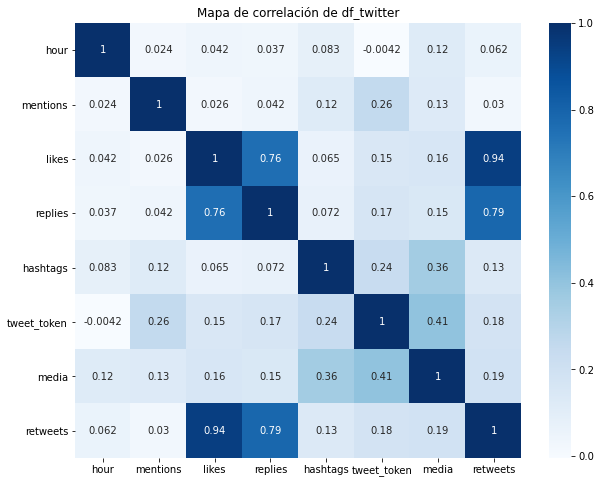

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(df_twitter.corr(),annot=True,ax=ax,cmap="Blues")
ax.set_title('Mapa de correlación de df_twitter')

<div class="alert alert-success">
  <strong>Los likes y replies son una excelente entrada para nuestro modelo!</strong> Al ver la gran relación que existe entre los retweets con los likes y replies se los considera entradas perfectas para nuestro modelo de regresión.</div>

<div class="alert alert-danger">
  <strong>La hora no es determinante en un tweet</strong> Si bien en el procesamiento habíamos comentado la importancia de la hora al momento de realizar un tweet, en este mapa nos damos cuenta la poca relación que tiene la hora con los retweets.</div>

Con este pequeño análisis que realizamos podemos empezar a crear nuestro modelo de regresión a partir de los datos de entrada que hemos escogído por el análisis realizado

## Modelo de regresión

Ahora procedemos a realizar los modelos de regresión para predecir la popularidad de un tweet dado ciertas entreadas, en este caso escogímos como entrada los likes y replies, mientras que para la salida serán los retweets. Para realizar este modelo tomaremos muy en cuenta el problema de overfitting, para ello realizaremos una división de train y test diferente utilizando cross validation.

### División train test con cross validation

Para estom utilizamos el cross_val_score que nos permite obtener un score de la validación cruzada tomando en cuenta el modelo y los valores de entrada y salida. Hemos probado con distintos regresores, entre los cuales estan lineales,regularizadores y robustos. Se obtuvo los siguientes resultados

In [17]:
def cross_score(model,x,y,cv=4):
    score = cross_val_score(model,x,y,cv=cv)
    return np.mean(score)

#datos de entrada
features = ['likes','replies']

#entradas y salidas
x = df_twitter[features]
y = df_twitter['retweets']

#kfold
kf = KFold(n_splits=4, shuffle=True, random_state=42)

#modelos de regresión
models = {
    'LINEAR' : LinearRegression(),
    'POLY'   : Pipeline([('poly', PolynomialFeatures(degree=3)),
                         ('linear', LinearRegression())]),
    'RIDGE'  : Ridge(alpha=1),
    'LASSO'  : Lasso(alpha=0.02),
    'HUBER'  : HuberRegressor(epsilon=1.35),
    'RANSAC' : RANSACRegressor()
}

#resultados
for name,estimator in models.items():
    print('{} score is : {:,.3f}'.format(name,cross_score(estimator,x,y,kf)))

LINEAR score is : 0.900
POLY score is : 0.921
RIDGE score is : 0.900
LASSO score is : 0.900
HUBER score is : 0.893
RANSAC score is : 0.745


Como podemos notar, el mejor regresor es el polinomial, mientras que el lineal, ridge,lasso mantienen valores iguales, por otro lado vemos que los regresores robustos como HUBER y RANSAC tienen distintos resultados donde RANSAC es el peor de todos. Con esto en cuenta y viendo que hemos podido realizar varias pruebas con varios modelos, decidímos utilizar el **regresor polinomial**.

### Regresión polinomial

Como habíamos indicado anteriormente, este regresor fue el mejor de todos en cuanto al cross validation de k-folds. Con ello en cuenta procedemos a realizar el entreamiento kfold.

In [18]:
model_poly = models['POLY']
for train,test in kf.split(df_twitter):
    x_train = x[features].iloc[train]
    y_train = y.iloc[train]
    x_test = x[features].iloc[test]
    y_test = y.iloc[test]
    model_poly.fit(x_train,y_train)

print('POLYNOMIAL SCORE IS: {:,.3f}'.format(model_poly.score(x,y)))
predict = model_poly.predict(x)
data = pd.DataFrame({'index':x['likes'],'real':y,'predict':predict})

POLYNOMIAL SCORE IS: 0.923


Como podemos notar en el score, su valor es el óptimo obtenido por el cross-validation, haciendo que nuestro modelo este correcto y este óptimo sin sufrir overfitting. Ahora realizaremos un pequeño gráfico con ciertos datos para verificar los datos predecidos de los reales

In [19]:
sample = data[data['real']>=100].head(20)
chart=alt.Chart(sample).mark_point(color='orange').encode(
    x='index',
    y=alt.Y('real',title='retweet')
    )+alt.Chart(sample).mark_line(color='red').encode(
        x=alt.X('index',title='likes'),
        y='predict'
    )
chart.properties(title='Test VS Predict').interactive()

alt.LayerChart(...)

A primera vista, la gráfica pareciera como si se presentara un overfitting, pero no es así, al tener un modelo de regresión de multivariables, la curva se ajusta mejor, sin embargo esto no es overfitting por dos razones **el score obtenido** es el adecuado al del cross-validation y **no estan conectados todos los puntos** y al no tener eso significa que se esta tratando de ajusta de la mejor manera

### Predicciones

Un modelo de regresión no nos serviría de nada si no procedemos a realizar predicciones, para ello vamos a tomar tweets de ejemplo:

Vamos a tomar un tweet de Guillermo Lasso el cual tiene 3800 likes y 98 comentarios, con esta cifra se tiene un total de 614 retweets. Con esto en mente procedemos a realizar la predicción

In [20]:
likes   = 3800
replies = 98
score= model_poly.score(x,y)*100
value_p = model_poly.predict(np.array([likes,replies]).reshape(1,-1))
print('El tweet con {} likes y {} respuestas predice {:,.0f} retweets con una presición de {:,.3f}%'.format(likes,replies,value_p[0],score))

El tweet con 3800 likes y 98 respuestas predice 644 retweets con una presición de 92.330%


Ahora vamos a realizar la predicción con otro tweet que tiene 660 likes y 26 replies, con esta cifra se tiene un total de 184 retweets. Con esto en mente, procedemos a realizar la predicción.

In [21]:
likes   = 660
replies = 26
score= model_poly.score(x,y)*100
value_p = model_poly.predict(np.array([likes,replies]).reshape(1,-1))
print('El tweet con {} likes y {} respuestas predice {:,.0f} retweets con una presición de {:,.3f}%'.format(likes,replies,value_p[0],score))

El tweet con 660 likes y 26 respuestas predice 130 retweets con una presición de 92.330%


<div class="alert alert-success">
  <strong>Nuestro modelo predice valores cercanos!</strong> Recordemos que el score de nuestro modelo es de 90% por lo que existe un 10% de error, por lo tanto, tomando en cuenta ello, nuestro modelo predice correctamente.</div>


<div class="alert alert-danger">
  <strong>Se recomienda usar técnicas de NPL!</strong> Si bien el machine learning ayuda a predecir la tendencia de tweets, no estamos tomando en cuenta procesos NPL los cuales ayudan a mejorar las predicciones para visualizar la popularidad de un post, ya que estas permiten analizar el téxto como tal.</div>


# Simulación del proceso de vacunación en Ecuador

![ecuador logo](https://www.eldiario.ec/wp-content/uploads/2021/05/1500x500-1024x341.jpg)

se debe seguir un procesos de vacunación en los recintos electorales que se describe a continuación:

Solo se va a tener en cuanta uno de los recintos electorales (investigar datos de cuantas personas asisten a votar).
*	Tomar los resultados de la regresión para la vacuna según la llegada.
*	Se tiene una promedio que el 80% de personas realizaran el proceso de vacunación dentro del Ecuador.
*	Dentro del procesos se tiene que alrededor del 5% - 10% no podrán vacunarse.
*	Las personas solo tiene un recinto electoral para realizar el proceso.
*	Las personas realizan la primera vacuna y 30 días después la segunda vacuna.
*	La persona se acerca a la mesa  y hacen fila en caso de ser necesario para recibir la vacuna.
*	Realiza la vacunación en un tiempo aleatorio entre 5 a 10 minutos.
*	Debe esperar 20 minutos dentro del establecimiento para verificar que no tenga problemas de salud.
*	La persona recibe su certificado de vacunación y la fecha de la próxima vacuna entre 2 – 3 minutos.
*	La persona sale del recinto electoral.
*	Regresan para la próxima fecha y se repite el ciclo.

Deben calcularse las siguientes métricas del sistema de simulación de eventos discretos :
*	Total de de personas que realizaron el proceso de vacunación.
*	Grafico del porcentaje de personas que no recibieron la vacuna.
*	El tiempo promedio de espera.

**Estos requerimientos cambiaran acorde a la simulación que se realizará.**

## Proceso de vacunación

Actualmente, con la llegada del nuevo gobierno, en el cual se ha posesionado el señor Guillermo Lasso como nuevo presidente de la república del Ecuador, en su plan de gobierno se tiene el plan de vacunación denominado 9-100. Este plan consiste en vacunar a 9 millones de Ecuatorianos en 100 días. Por tanto, el día 31/05/2021 a las 12:30 se ha presentado el plan de vacunación. Por tanto este plan consta de la siguiente manera:

* Se tendra ayuda del CNE y del ministerio de educación para vacunar a la gente utilizando su padrón electoral y los recintos electorales autorizados para la vacunación.
* Hasta el momento se cuenta con 317 recintos electorales en donde se realizará el proceso de vacunación.
* Se tomara en cuenta que cada día se vacunara al rededor de 100 personas en cada recinto.
* El horario de vacunación se realizara de 8:00 am a 17:00 pm de Lunes a Domingo.
* No se ha específicado la cantidad de personal para cada recinto, sin embargo, podríamos decir que puede existir al rededor de 5 personas en mesa, 5 personas que realizan el examen, 5 personas que toman los datos, 5 personas que realizan el proceso de vacunación y entregan el certificado creado por la persona que toma los datos, contanto al final con un total de 15 trabajadores en el recinto.
* El plan de vacunación constara de varias fases, entre las cuales se tiene prioridad a la línea de fuego en donde tenemos a (policias,medicos,militares,mayores de edad con discapacidad y enfermedades)
* El resto de personas que no esta en dicha línea debera esperar su respectiva fase.

El gobierno actualmente cuenta con 700 mil vacunas las cuales sera repartidas en todos los recintos, no se tiene estimado cuantas vacunas se distribuiran, sin embargo,tomando en cuenta el número de vacunados por día, se estimaría que llegarían 700 vacunas semanales.


* Para más información sobre el plan de vacunación tomar hacer click: **<a href="https://guillermolasso.ec/9-millones-de-vacunas/">[aquí]</a>**

* Para saber donde es tu lugar de vacunación hacer click: **<a href="https://lugarvacunacion.cne.gob.ec/">[aqui]</a>**

* Para saber sobre el proceso de plan 9-100 hacer click: **<a href = "https://www.facebook.com/LassoGuillermo/videos/384590036215906">[aquí]</a>**

In [22]:
from IPython.display import HTML

HTML('<iframe src="https://www.facebook.com/plugins/video.php?height=314&href=https%3A%2F%2Fwww.facebook.com%2FLassoGuillermo%2Fvideos%2F384590036215906%2F&show_text=false&width=560&t=0" width="560" height="314" style="border:none;overflow:hidden" scrolling="no" frameborder="0" allowfullscreen="true" allow="autoplay; clipboard-write; encrypted-media; picture-in-picture; web-share" allowFullScreen="true"></iframe>')

## Proceso de simulación

Una vez explicado el proceso de vacunación, procedemos a explicar como se va a realizar el proceso de simulación. Tomemos en cuenta que vamos a simular **1 recinto para 1 día**, eso quiere decir que vamos a necesitar 100 vacunas y 15 personas para dicho recinto. Esta simulación nos ayudara a estimar como se realizara la vacunación en los siguientes días en varios recintos. Ademas tomemos en cuenta que **1 día** significa que estara en el horario de **8:00am a 17:00pm**. Con esta consideración procedemos a realizar los pasos de simulación.

### Importar librerias

La librería que vamos a importar para realizar el proceso de simulación es Simpy. Esta es una librería que permite realizar simulaciones de eventos discretos de una manera rapida con una curva de aprendizaje muy alta. Ademas de ello utilizaremos la librería random para generar valores pseudoaleatorios.

In [23]:
import datetime as dt
import plotly.express as px
import plotly
plotly.offline.init_notebook_mode(connected=True)
import random
import simpy

from datetime import datetime

### Determinamos los parámetros de nuestra simulación

Para los parametros de nuestra simulación hemos tomado en cuenta las siguientes consideraciones:

* **número de vacunas:** En este caso seran 100 según lo explicado en el punto de proceso de simulación.
* **número de personas en mesa:** Seran 5 personas asignadas para este recurso
* **número de personas que realizan examen:** Seran 5 personas asignadas para este recurso
* **número de personas que vacunan y dan el certificado:** Seran 5 personas asignadas para este recurso
* **intervalo de llegada de ciudadanos**: En este caso tomaremos en cuenta que cada ciudadano lleg al rededor de 3 a 5 min a su recento electoral.
* **tiempo de simulación**: Tomando en cuenta el horario explicado en el punto de proceso de simulación se realiara una simulación de 540 min
* **fecha de la siguiente vacunación:** Tomando en cuenta que la segunda dosis se realizara después de 21 días procederemos a realizar una fecha constante ya que las personas que se vacunaran tendran la misma fecha de segunda dosis. (En caso de que no se pueden vacunar por que no pasarón e proceso de revisión se le asignara una fecha aleatoria a partir de la actual)
* **recolector de datos:** Aqui vamos a recolectar los datos de las personas que entraron a la simulación tomando los tiempos

**Requerimientos de la simulación**

* Se tiene una promedio que el 80% de personas realizaran el proceso de vacunación dentro del Ecuador.
* Dentro del procesos se tiene que alrededor del 5% - 10% no podrán vacunarse.
* Las personas realizan la primera vacuna y 21 días después la segunda vacuna.
* La persona se acerca a la mesa y hacen fila en caso de ser necesario para recibir la vacuna.
* Realiza la vacunación en un tiempo aleatorio entre 5 a 10 minutos.
* Debe esperar 20 minutos dentro del establecimiento para verificar que no tenga problemas de salud.
* La persona recibe su certificado de vacunación y la fecha de la próxima vacuna entre 2 – 3 minutos.
* La persona sale del recinto electoral.
* Regresan para la próxima fecha y se repite el ciclo. 

**Requerimientos que no aplican para esta simulación**

* Las personas solo tiene un recinto electoral para realizar el proceso **(esto es obvio ya que solo se simula un recinto)**

In [24]:
NUM_VACCINES                = 100
NUM_PERSON_VACCINES         = 5
NUM_PERSON_EXAM             = 5
NUM_PERSON_CERTIFICATE      = 5
TIME_SIMULATION             = 540
INTERVAL                    = 5
DATE_NOW                    = datetime.now().strftime('%Y/%m/%d')
LIST_DATA                   = set()
DATA_PERSON                 = []
DAY                         = 21
GLOBAL_ID                   = 1

### Clases para la simulación

Para realizar la simulación, vamos a utilizar clases ya que estas nos permiten manejar de forma más ordenada la simulación. Tomando en cuenta esto vamos a realizar las siguientes clases:

* **Person:** El ciudadano a vacunarse
* **Vacunation:** Clase que se encarga del proceso de vacunación
* **Simulation:** Clase que realizar la simulación
* **ProblemExamException:** Clase de excepción para try-catch
* **VaccineException:** Clase de excepción para try-catch

In [25]:
class ProblemExamException(Exception):
    pass


class VaccineException(Exception):
    pass


class Person():
    def __init__(self, name,datetime):
        self.name = name
        self.problem = 0
        self.first_cite = datetime
        self.second_cite = ''
        self.date = datetime
        self.dose = 0

class Vacunation():
    
    def __init__(self,env):
        global NUM_PERSON_VACCINES, NUM_PERSON_EXAM, NUM_PERSON_CERTIFICATE, NUM_VACCINES
        self.env = env
        self.person_v = simpy.Resource(env, NUM_PERSON_VACCINES)
        self.person_e = simpy.Resource(env, NUM_PERSON_EXAM)
        self.person_c = simpy.Resource(env, NUM_PERSON_CERTIFICATE)
        self.vaccines = NUM_VACCINES
        self.exam = None
        self.probability = [0.8, 0.5]
        self.exam_result = [0, 1]
        
    def _exam_process(self, time):
        self.exam = random.choices(self.exam_result, self.probability, k=1)
        yield self.env.timeout(time)

    def _data_process(self, time):
        yield self.env.timeout(time)

    def _vaccine_process(self, time):
        self.vaccines = self.vaccines-1
        yield self.env.timeout(time)

    def _certificate_process(self, time):
        yield self.env.timeout(time)

    def _exit_process(self, time):
        yield self.env.timeout(time)
    
    def _cite_reschedule(self,person,message):
        if(person.dose<2):
            person.first_cite = datetime.strftime(datetime.strptime(person.first_cite, '%Y/%m/%d')+dt.timedelta(days=random.randint(2,5)), '%Y/%m/%d')
            self._print_process(person.name,self.env.now,message.format(person.first_cite))
        elif(person.dose==2):
            person.second_cite = datetime.strftime(datetime.strptime(person.second_cite, '%Y/%m/%d')+dt.timedelta(days=random.randint(2,5)), '%Y/%m/%d')
            self._print_process(person.name,self.env.now,message.format(person.second_cite))
        return person

    def _print_process(self, person, hour, action):
        print('persona:[{}] - hora:[{:,.2f}] - acción: [{}]'.format(person, hour, action))

    def _vacunation_process(self,person):
        global LIST_DATE,DATA_PERSON,DAY
        
        time_exam        = 0
        time_data        = 0
        time_vaccine     = 0
        time_certificate = 0
        time_wait        = 0
        time_wait_mean   = 0
        time_exit        = 0
        
        if(person.dose==0):
            self._print_process(person.name,self.env.now,'llega la persona al recinto con primera cita: {}'.format(person.first_cite))
        else:
            self._print_process(person.name,self.env.now,'llega la persona al recinto con segunda cita: {}'.format(person.second_cite))
        
        wait=self.env.now
        with self.person_e.request() as mesa:
            yield mesa
            self._print_process(person.name, self.env.now, 'llega a la mesa')
            time_wait = self.env.now -wait
            time_wait_mean+=time_wait
            time_exam = 20
            yield self.env.process(self._exam_process(time_exam))
        
        try:
            if(self.vaccines>0):
                try:
                    if(self.exam[0] == 0):
                        self._print_process(person.name, self.env.now, 'pasa el proceso de revisión')
                        
                        wait=self.env.now
                        with self.person_c.request() as certificate:
                            yield certificate
                            time_data = random.randint(2, 4)
                            time_wait = self.env.now -wait
                            time_wait_mean+=time_wait
                            yield self.env.process(self._data_process(time_data))
                            self._print_process(person.name, self.env.now, 'se tomaron los datos correctamente')
                        
                        wait=self.env.now
                        with self.person_v.request() as vaccine:
                            yield vaccine
                            try:
                                if(self.vaccines>0):
                                    time_wait = self.env.now - wait
                                    time_wait_mean+=time_wait
                                    time_vaccine = random.randint(5, 10)
                                    yield env.process(self._vaccine_process(time_vaccine))
                                    self._print_process(person.name, self.env.now, 'vacuna puesta')

                                    time_certificate = random.randint(1, 3)
                                    yield env.process(self._certificate_process(time_certificate))
                                    
                                    
                                    if(person.dose==0):
                                        person.dose+=1
                                        person.second_cite = datetime.strftime(datetime.strptime(person.first_cite, '%Y/%m/%d')+dt.timedelta(days=DAY), '%Y/%m/%d')
                                        self._print_process(person.name, self.env.now, 'se le entrega el certificado con fecha a la segunda dosis {}'.format(person.second_cite))
                                    elif(person.dose==1):
                                        person.dose+=1
                                        self._print_process(person.name,self.env.now,'se entraga el certificado con todas las dosis')
                                    
                                else:
                                    raise VaccineException
                                    
                            except VaccineException:
                                person = self._cite_reschedule(person,'no hay vacunas, se reagenda la cita a {}')
                    else:
                        raise ProblemExamException
                except ProblemExamException:
                    person = self._cite_reschedule(person,'no pasa el proceso de revisión, se reagenda la cita a {}')
                
            else:
                raise VaccineException
        except VaccineException:
            person = self._cite_reschedule(person,'no hay vacunas, se reagenda la cita a {}')
        
        time_exit = random.randint(1,5)
        yield env.process(self._exit_process(time_exit))
        self._print_process(person.name,self.env.now,'sale del recinto')
        LIST_DATA.add(person)
        DATA_PERSON.append((person.name,person.date,person.first_cite,person.second_cite,person.dose,time_wait,time_exam,time_data,time_vaccine,time_certificate,time_exit))
            
            



class Simulation():
    def __init__(self,init,day,persons,date):
        global DATE_NOW,GLOBAL_ID
        self.init = init
        self.name = 'persona_{}'
        self.day = day
        self.date = date
        self.persons = persons
    
    def _execute_simulation(self,env):
        global INTERVAL,GLOBAL_ID
        vacunation = Vacunation(env)
        if(len(self.persons)>0 and self.day>0):
            self._init_list_persons(env,vacunation)
        else:    
            self._init_persons(env,vacunation)
        
        while True:
            yield env.timeout(random.randint(INTERVAL-2,INTERVAL))
            name = self.name.format(GLOBAL_ID)
            person = Person(name,self.date)
            env.process(vacunation._vacunation_process(person))
            GLOBAL_ID+=1
        
    def _init_persons(self,env,vacunation):
        global GLOBAL_ID
        for i in range(self.init):
            name = self.name.format(GLOBAL_ID)
            GLOBAL_ID+=1
            person = Person(name,self.date)
            env.process(vacunation._vacunation_process(person))
    
    def _init_list_persons(self,env,vacunation):
        for i in self.persons:
            env.process(vacunation._vacunation_process(i))
        
        


### Pruebas de la simulación


Con estas pruebas, vamos a poder determinar la tendencia de como se comportaran los recintos frente al proceso de vacunación que se tendra en el Ecuador. Simulamos el recinto UPS (Universidad Politécnica Salesiana)

In [26]:
date = datetime.strftime(datetime.strptime(DATE_NOW, '%Y/%m/%d'),'%Y/%m/%d')
second_dose_date = datetime.strftime(datetime.strptime(DATE_NOW, '%Y/%m/%d')+dt.timedelta(days=DAY), '%Y/%m/%d')
persons = []
i=0

while (date!=second_dose_date):
    print("="*10,'FECHA {}'.format(date),"="*10)
    env = simpy.Environment()
    if(i>0):
        simulation = Simulation(len(persons),i,persons,date)
    else:
        simulation = Simulation(7,i,persons,date)
    env.process(simulation._execute_simulation(env))
    env.run(until=TIME_SIMULATION)
    i+=1
    date = datetime.strftime(datetime.strptime(date, '%Y/%m/%d')+dt.timedelta(days=1), '%Y/%m/%d')
    persons = [i for i in LIST_DATA if i.first_cite == date] 

print("*"*10,"DIA DE LA SEGUNDA DOSIS","*"*10)
persons = [i for i in LIST_DATA if i.first_cite == second_dose_date or i.second_cite == second_dose_date]
env = simpy.Environment()
simulation = Simulation(len(persons),i,persons,date)
env.process(simulation._execute_simulation(env))
env.run(until=TIME_SIMULATION)

========== FECHA 2021/06/03 ==========
persona:[persona_1] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/03]
persona:[persona_2] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/03]
persona:[persona_3] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/03]
persona:[persona_4] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/03]
persona:[persona_5] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/03]
persona:[persona_6] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/03]
persona:[persona_7] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/03]
persona:[persona_1] - hora:[0.00] - acción: [llega a la mesa]
persona:[persona_2] - hora:[0.00] - acción: [llega a la mesa]
persona:[persona_3] - hora:[0.00] - acción: [llega a la mesa]
persona:[persona_4] - hora:[0.00] - acción: [llega a l

persona:[persona_272] - hora:[525.00] - acción: [llega a la mesa]
persona:[persona_266] - hora:[526.00] - acción: [se tomaron los datos correctamente]
persona:[persona_267] - hora:[526.00] - acción: [sale del recinto]
persona:[persona_264] - hora:[527.00] - acción: [sale del recinto]
persona:[persona_275] - hora:[529.00] - acción: [llega la persona al recinto con primera cita: 2021/06/04]
persona:[persona_268] - hora:[529.00] - acción: [pasa el proceso de revisión]
persona:[persona_265] - hora:[529.00] - acción: [vacuna puesta]
persona:[persona_273] - hora:[529.00] - acción: [llega a la mesa]
persona:[persona_265] - hora:[532.00] - acción: [se le entrega el certificado con fecha a la segunda dosis 2021/06/25]
persona:[persona_268] - hora:[532.00] - acción: [se tomaron los datos correctamente]
persona:[persona_266] - hora:[533.00] - acción: [vacuna puesta]
persona:[persona_276] - hora:[534.00] - acción: [llega la persona al recinto con primera cita: 2021/06/04]
persona:[persona_269] - h

persona:[persona_417] - hora:[100.00] - acción: [no pasa el proceso de revisión, se reagenda la cita a 2021/06/10]
persona:[persona_418] - hora:[100.00] - acción: [llega a la mesa]
persona:[persona_419] - hora:[100.00] - acción: [llega a la mesa]
persona:[persona_420] - hora:[100.00] - acción: [llega a la mesa]
persona:[persona_421] - hora:[100.00] - acción: [llega a la mesa]
persona:[persona_422] - hora:[100.00] - acción: [llega a la mesa]
persona:[persona_115] - hora:[103.00] - acción: [sale del recinto]
persona:[persona_415] - hora:[103.00] - acción: [sale del recinto]
persona:[persona_440] - hora:[104.00] - acción: [llega la persona al recinto con primera cita: 2021/06/06]
persona:[persona_79] - hora:[104.00] - acción: [sale del recinto]
persona:[persona_416] - hora:[104.00] - acción: [sale del recinto]
persona:[persona_417] - hora:[104.00] - acción: [sale del recinto]
persona:[persona_441] - hora:[107.00] - acción: [llega la persona al recinto con primera cita: 2021/06/06]
persona

persona:[persona_622] - hora:[288.00] - acción: [llega la persona al recinto con primera cita: 2021/06/07]
persona:[persona_589] - hora:[288.00] - acción: [vacuna puesta]
persona:[persona_590] - hora:[288.00] - acción: [vacuna puesta]
persona:[persona_589] - hora:[289.00] - acción: [se le entrega el certificado con fecha a la segunda dosis 2021/06/28]
persona:[persona_592] - hora:[290.00] - acción: [vacuna puesta]
persona:[persona_590] - hora:[290.00] - acción: [se le entrega el certificado con fecha a la segunda dosis 2021/06/28]
persona:[persona_592] - hora:[291.00] - acción: [se le entrega el certificado con fecha a la segunda dosis 2021/06/28]
persona:[persona_591] - hora:[292.00] - acción: [vacuna puesta]
persona:[persona_593] - hora:[292.00] - acción: [vacuna puesta]
persona:[persona_592] - hora:[292.00] - acción: [sale del recinto]
persona:[persona_623] - hora:[293.00] - acción: [llega la persona al recinto con primera cita: 2021/06/07]
persona:[persona_590] - hora:[293.00] - ac

persona:[persona_799] - hora:[450.00] - acción: [llega la persona al recinto con primera cita: 2021/06/08]
persona:[persona_800] - hora:[454.00] - acción: [llega la persona al recinto con primera cita: 2021/06/08]
persona:[persona_801] - hora:[459.00] - acción: [llega la persona al recinto con primera cita: 2021/06/08]
persona:[persona_761] - hora:[460.00] - acción: [pasa el proceso de revisión]
persona:[persona_762] - hora:[460.00] - acción: [pasa el proceso de revisión]
persona:[persona_763] - hora:[460.00] - acción: [pasa el proceso de revisión]
persona:[persona_764] - hora:[460.00] - acción: [pasa el proceso de revisión]
persona:[persona_765] - hora:[460.00] - acción: [pasa el proceso de revisión]
persona:[persona_766] - hora:[460.00] - acción: [llega a la mesa]
persona:[persona_767] - hora:[460.00] - acción: [llega a la mesa]
persona:[persona_768] - hora:[460.00] - acción: [llega a la mesa]
persona:[persona_769] - hora:[460.00] - acción: [llega a la mesa]
persona:[persona_770] - h

persona:[persona_997] - hora:[340.00] - acción: [sale del recinto]
persona:[persona_1004] - hora:[340.00] - acción: [llega a la mesa]
persona:[persona_1005] - hora:[340.00] - acción: [llega a la mesa]
persona:[persona_1006] - hora:[340.00] - acción: [llega a la mesa]
persona:[persona_1007] - hora:[340.00] - acción: [llega a la mesa]
persona:[persona_1008] - hora:[340.00] - acción: [llega a la mesa]
persona:[persona_1002] - hora:[342.00] - acción: [se tomaron los datos correctamente]
persona:[persona_1003] - hora:[342.00] - acción: [se tomaron los datos correctamente]
persona:[persona_1038] - hora:[343.00] - acción: [llega la persona al recinto con primera cita: 2021/06/10]
persona:[persona_1000] - hora:[343.00] - acción: [se tomaron los datos correctamente]
persona:[persona_999] - hora:[344.00] - acción: [se tomaron los datos correctamente]
persona:[persona_1001] - hora:[344.00] - acción: [se tomaron los datos correctamente]
persona:[persona_1039] - hora:[346.00] - acción: [llega la pe

persona:[persona_1247] - hora:[240.00] - acción: [llega a la mesa]
persona:[persona_1248] - hora:[240.00] - acción: [llega a la mesa]
persona:[persona_1249] - hora:[240.00] - acción: [llega a la mesa]
persona:[persona_1280] - hora:[241.00] - acción: [llega la persona al recinto con primera cita: 2021/06/12]
persona:[persona_1243] - hora:[241.00] - acción: [sale del recinto]
persona:[persona_1244] - hora:[242.00] - acción: [sale del recinto]
persona:[persona_1241] - hora:[244.00] - acción: [sale del recinto]
persona:[persona_1242] - hora:[244.00] - acción: [sale del recinto]
persona:[persona_1281] - hora:[245.00] - acción: [llega la persona al recinto con primera cita: 2021/06/12]
persona:[persona_1240] - hora:[245.00] - acción: [sale del recinto]
persona:[persona_1282] - hora:[249.00] - acción: [llega la persona al recinto con primera cita: 2021/06/12]
persona:[persona_1283] - hora:[254.00] - acción: [llega la persona al recinto con primera cita: 2021/06/12]
persona:[persona_1284] - ho

persona:[persona_859] - hora:[140.00] - acción: [llega a la mesa]
persona:[persona_1188] - hora:[141.00] - acción: [sale del recinto]
persona:[persona_1240] - hora:[142.00] - acción: [sale del recinto]
persona:[persona_1186] - hora:[143.00] - acción: [sale del recinto]
persona:[persona_1528] - hora:[144.00] - acción: [llega la persona al recinto con primera cita: 2021/06/14]
persona:[persona_308] - hora:[145.00] - acción: [sale del recinto]
persona:[persona_1265] - hora:[145.00] - acción: [sale del recinto]
persona:[persona_1529] - hora:[149.00] - acción: [llega la persona al recinto con primera cita: 2021/06/14]
persona:[persona_1530] - hora:[152.00] - acción: [llega la persona al recinto con primera cita: 2021/06/14]
persona:[persona_1531] - hora:[157.00] - acción: [llega la persona al recinto con primera cita: 2021/06/14]
persona:[persona_1532] - hora:[160.00] - acción: [llega la persona al recinto con primera cita: 2021/06/14]
persona:[persona_237] - hora:[160.00] - acción: [no pas

persona:[persona_1783] - hora:[87.00] - acción: [llega la persona al recinto con primera cita: 2021/06/16]
persona:[persona_1784] - hora:[91.00] - acción: [llega la persona al recinto con primera cita: 2021/06/16]
persona:[persona_1785] - hora:[94.00] - acción: [llega la persona al recinto con primera cita: 2021/06/16]
persona:[persona_1786] - hora:[97.00] - acción: [llega la persona al recinto con primera cita: 2021/06/16]
persona:[persona_40] - hora:[100.00] - acción: [pasa el proceso de revisión]
persona:[persona_1260] - hora:[100.00] - acción: [pasa el proceso de revisión]
persona:[persona_1152] - hora:[100.00] - acción: [pasa el proceso de revisión]
persona:[persona_1301] - hora:[100.00] - acción: [pasa el proceso de revisión]
persona:[persona_1155] - hora:[100.00] - acción: [pasa el proceso de revisión]
persona:[persona_1169] - hora:[100.00] - acción: [llega a la mesa]
persona:[persona_890] - hora:[100.00] - acción: [llega a la mesa]
persona:[persona_1165] - hora:[100.00] - acció

persona:[persona_1434] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/18]
persona:[persona_1241] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/18]
persona:[persona_1376] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/18]
persona:[persona_1415] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/18]
persona:[persona_1655] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/18]
persona:[persona_1169] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/18]
persona:[persona_1005] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/18]
persona:[persona_351] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/18]
persona:[persona_212] - hora:[0.00] - acción: [llega la persona al recinto con primera cita: 2021/06/18]
persona:[persona_1640] - hora:[0.00] - acción: [

persona:[persona_2272] - hora:[426.00] - acción: [llega la persona al recinto con primera cita: 2021/06/19]
persona:[persona_2219] - hora:[429.00] - acción: [vacuna puesta]
persona:[persona_2221] - hora:[430.00] - acción: [vacuna puesta]
persona:[persona_2219] - hora:[430.00] - acción: [se le entrega el certificado con fecha a la segunda dosis 2021/07/10]
persona:[persona_2273] - hora:[431.00] - acción: [llega la persona al recinto con primera cita: 2021/06/19]
persona:[persona_2217] - hora:[431.00] - acción: [vacuna puesta]
persona:[persona_2219] - hora:[431.00] - acción: [sale del recinto]
persona:[persona_2220] - hora:[432.00] - acción: [vacuna puesta]
persona:[persona_2221] - hora:[432.00] - acción: [se le entrega el certificado con fecha a la segunda dosis 2021/07/10]
persona:[persona_2218] - hora:[433.00] - acción: [vacuna puesta]
persona:[persona_2217] - hora:[433.00] - acción: [se le entrega el certificado con fecha a la segunda dosis 2021/07/10]
persona:[persona_2221] - hora:[

persona:[persona_2453] - hora:[272.00] - acción: [se le entrega el certificado con fecha a la segunda dosis 2021/07/12]
persona:[persona_2449] - hora:[273.00] - acción: [sale del recinto]
persona:[persona_2452] - hora:[273.00] - acción: [se le entrega el certificado con fecha a la segunda dosis 2021/07/12]
persona:[persona_2450] - hora:[273.00] - acción: [se le entrega el certificado con fecha a la segunda dosis 2021/07/12]
persona:[persona_2453] - hora:[273.00] - acción: [sale del recinto]
persona:[persona_2505] - hora:[274.00] - acción: [llega la persona al recinto con primera cita: 2021/06/21]
persona:[persona_2450] - hora:[274.00] - acción: [sale del recinto]
persona:[persona_2451] - hora:[275.00] - acción: [sale del recinto]
persona:[persona_2452] - hora:[275.00] - acción: [sale del recinto]
persona:[persona_2506] - hora:[279.00] - acción: [llega la persona al recinto con primera cita: 2021/06/21]
persona:[persona_2454] - hora:[280.00] - acción: [pasa el proceso de revisión]
perso

persona:[persona_2716] - hora:[200.00] - acción: [llega a la mesa]
persona:[persona_2761] - hora:[201.00] - acción: [llega la persona al recinto con primera cita: 2021/06/23]
persona:[persona_854] - hora:[202.00] - acción: [se tomaron los datos correctamente]
persona:[persona_2710] - hora:[202.00] - acción: [se tomaron los datos correctamente]
persona:[persona_2711] - hora:[202.00] - acción: [se tomaron los datos correctamente]
persona:[persona_2762] - hora:[204.00] - acción: [llega la persona al recinto con primera cita: 2021/06/23]
persona:[persona_2374] - hora:[204.00] - acción: [se tomaron los datos correctamente]
persona:[persona_2335] - hora:[204.00] - acción: [se tomaron los datos correctamente]
persona:[persona_2763] - hora:[208.00] - acción: [llega la persona al recinto con primera cita: 2021/06/23]
persona:[persona_854] - hora:[209.00] - acción: [vacuna puesta]
persona:[persona_2711] - hora:[209.00] - acción: [vacuna puesta]
persona:[persona_854] - hora:[210.00] - acción: [se

## Métrcias de la simulación

Una vez realizadas las simulaciones, con la data recolectada procedemos a realizar el proceso de análisis de resultados de la simulación, tomando en cuenta los requerimientos indicados, se los modificarón y se obtuvieron las siguientes métricas:

* Total de personas que se vacunaron.
* Total de personas que no se vacunaron.
* porcentaje de personas vacunadas y no vacunadas.
* El tiempo promedio de espera

Cabe recalcar que todos los tiempos del conjunto de datos estan en minutos

In [27]:
df_data_simulation = pd.DataFrame(DATA_PERSON,columns=['name','date','first_cite','second_cite','dose','time_wait','time_exam','time_data','time_vaccine','time_certificate','time_exit'])
df_data_simulation['time_total'] = df_data_simulation['time_wait']+df_data_simulation['time_exam']+df_data_simulation['time_data']+df_data_simulation['time_vaccine']+df_data_simulation['time_certificate']+df_data_simulation['time_exit']
df_data_simulation=df_data_simulation.sort_values(['first_cite','second_cite'])
df_data_simulation['id'] = df_data_simulation['name'].apply(lambda x:int(x.split('_')[1]))
df_data_simulation['date']=pd.to_datetime(df_data_simulation['date'])
df_data_simulation['first_cite']=pd.to_datetime(df_data_simulation['first_cite'])
df_data_simulation['second_cite']=pd.to_datetime(df_data_simulation['second_cite'])
df_data_simulation = df_data_simulation.drop_duplicates(['id'],keep='last')
df_data_simulation = df_data_simulation[['id','name','date','time_wait','first_cite','second_cite','dose','time_total']].sort_values(['id'])
df_data_simulation


,id,name,date,time_wait,first_cite,second_cite,dose,time_total
2797,1,persona_1,2021-06-03,0,2021-06-03,2021-06-24,2,38
2802,2,persona_2,2021-06-03,320,2021-06-07,2021-06-24,1,341
2808,3,persona_3,2021-06-03,0,2021-06-03,2021-06-24,2,36
2807,4,persona_4,2021-06-03,0,2021-06-03,2021-06-24,2,35
2812,5,persona_5,2021-06-03,0,2021-06-03,2021-06-24,2,34
...,...,...,...,...,...,...,...,...
2719,2787,persona_2787,2021-06-23,0,2021-06-23,2021-07-14,1,37
2716,2788,persona_2788,2021-06-23,0,2021-06-23,2021-07-14,1,31
2718,2789,persona_2789,2021-06-23,0,2021-06-23,2021-07-14,1,33
2720,2790,persona_2790,2021-06-23,0,2021-06-23,2021-07-14,1,38


Una vez preprocesado el conjunto de datos podemos notar como algunas personas no se vacunarón y otras personas si lograron vacunarse. A partir de estos obtenemos las siguientes métricas.

### metricas generales

In [28]:
print('Se ha llegado a un total de {} personas en el recinto'.format((len(df_data_simulation))))
print('Se ha vacunado a un total de {} personas'.format(len(df_data_simulation[df_data_simulation['dose']>=1])))
print('{} personas tienen la primera dosis'.format(len(df_data_simulation[df_data_simulation['dose']==1])))
print('{} personas tienen la segunda dosis'.format(len(df_data_simulation[df_data_simulation['dose']==2])))
print('{} personas no se han vacunado'.format(len(df_data_simulation[df_data_simulation['dose']==0])))

Se ha llegado a un total de 1930 personas en el recinto
Se ha vacunado a un total de 1773 personas
1714 personas tienen la primera dosis
59 personas tienen la segunda dosis
157 personas no se han vacunado


### Total de personas que se vacunaron en un día

In [29]:
data_fig = df_data_simulation[(df_data_simulation['dose']>=1)].sample(20)
fig = alt.Chart(data_fig).mark_trail(color='lightgrey').encode(
    x=alt.X('name',sort=alt.EncodingSortField(field="id", order='ascending')),
    y='time_total'
)+alt.Chart(data_fig).mark_point().encode(
    x = alt.X('name',sort=alt.EncodingSortField(field="id", order='ascending')),
    y = 'time_total',
    color = alt.condition(
            alt.datum.time_total == max(data_fig['time_total']),
            alt.value('red'),    
            alt.value('black')
            )
)
fig=fig.properties(title='Personas vacunadas en el recinto UPS-tiempo total')
fig

alt.LayerChart(...)

### Total de personas que no se vacunaron en un día

In [30]:
data_fig = df_data_simulation[(df_data_simulation['dose']==0)].sample(20)
fig_2 = alt.Chart(data_fig).mark_trail(color='lightgrey').encode(
    x=alt.X('name',sort=alt.EncodingSortField(field="id", order='ascending')),
    y='time_total'
)+alt.Chart(data_fig).mark_point().encode(
    x = alt.X('name',sort=alt.EncodingSortField(field="id", order='ascending')),
    y = 'time_total',
    color = alt.condition(
            alt.datum.time_total == max(data_fig['time_total']),
            alt.value('red'),    
            alt.value('black')
            )
)
fig_2 = fig_2.properties(title='Personas no vacunadas en el recinto UPS-tiempo total')
fig_2

alt.LayerChart(...)

### personas vacunadas y no vacunadas

In [31]:
fig&fig_2

alt.VConcatChart(...)

### porcentaje de personas vacunadas y no vacunas

In [32]:
df_percentage = pd.DataFrame([('primera dosis',len(df_data_simulation[df_data_simulation['dose']==1])/len(df_data_simulation)),
('segunda dosis',len(df_data_simulation[df_data_simulation['dose']==2])/len(df_data_simulation)),
('no vacunados',len(df_data_simulation[df_data_simulation['dose']==0])/len(df_data_simulation))],columns=['name','percentage'])
df_percentage.head()


,name,percentage
0,primera dosis,0.888083
1,segunda dosis,0.030570
2,no vacunados,0.081347


In [33]:
fig = px.pie(df_percentage, values="percentage",
             names="name", 
             color_discrete_sequence=['red','lightgrey','darkgrey'],width=1000,height=500)
fig.update_layout(title_text='Proceso de vacunación en recinto UPS', title_x=0.5)

### El tiempo promedio de espera

In [34]:
print('El promedio de tiempo de espera de las personas es: {:,.2f} min'.format(df_data_simulation['time_wait'].mean()))

El promedio de tiempo de espera de las personas es: 16.16 min


In [35]:
data_fig = df_data_simulation[df_data_simulation['time_wait']!=0].sample(20)
fig = alt.Chart(data_fig).mark_trail(color='lightgrey').encode(
    x=alt.X('name',sort=alt.EncodingSortField(field="id", order='ascending')),
    y='time_wait'
)+alt.Chart(data_fig).mark_point().encode(
    x = alt.X('name',sort=alt.EncodingSortField(field="id", order='ascending')),
    y = 'time_wait',
    color = alt.condition(
            alt.datum.time_wait == max(data_fig['time_wait']),
            alt.value('red'),    
            alt.value('black')
            )
)
fig=fig.properties(title='Tiempo de espera de personas en el recinto UPS')
fig

alt.LayerChart(...)

# Conclusiones

Tomando en cuenta todo lo realizado en este informe, hemos visto como las regresiones nos permiten tratar de predecir tendendicas, sin embargo, no es la mejor opción de todas ya que actualmente se tienen muchas más técnicas que pueden ser de más utilidad. Por otro lado también podemos notar que los scrping son muy importantes para la extracción de información. Por otro lado nos damos cuenta que la simulación es una herramienta muy poderosa para poder predecir lo que podría pasar en un evento o en una acción. Es importante recalcar que la simulación debe ir acompañada de buenas gráficas con el fin de entender de mejor manera el comportamiento de la simulación.